In [1]:
import jax
import numpyro

# For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_host_device_count(2)

# For CPU (use "gpu" for GPU)
numpyro.set_platform("cpu")

# For 64-bit precision since JAX defaults to 32-bit
jax.config.update("jax_enable_x64", True)

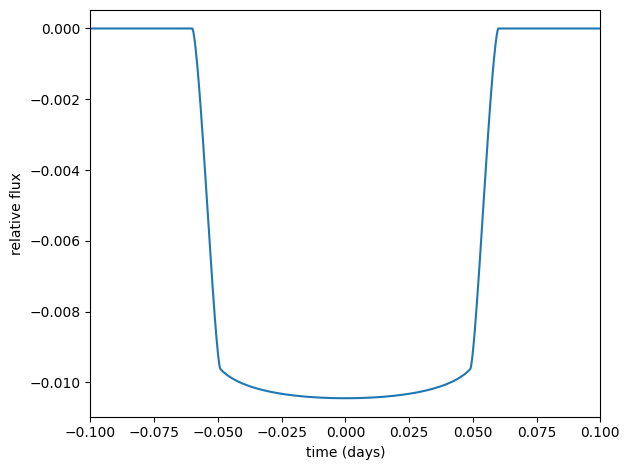

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

orbit = TransitOrbit(
    period=3.456, duration=0.12, time_transit=0.0, impact_param=0.0, radius_ratio=0.1
)

# Compute a limb-darkened light curve for this orbit
time = np.linspace(-0.1, 0.1, 1000)
u = [0.1, 0.06]  # Quadratic limb-darkening coefficients
light_curve = limb_dark_light_curve(orbit, u)(time)

# Plot the light curve
plt.plot(time, light_curve)
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
plt.tight_layout()

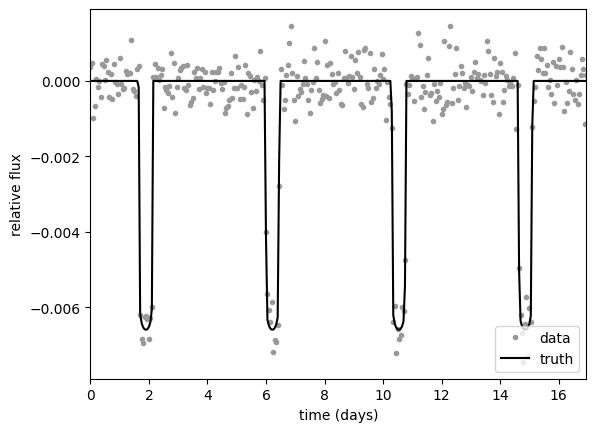

In [3]:
# Simulate some data with Gaussian noise
random = np.random.default_rng(42)
PERIOD = random.uniform(2, 5)  # day
T0 = PERIOD * random.uniform()  # day
DURATION = 0.5  # day
B = 0.5  # impact parameter
ROR = 0.08  # planet radius / star radius
U = np.array([0.1, 0.06])  # limb darkening coefficients
yerr = 5e-4  # flux uncertainty
time = np.arange(0, 17, 0.05)  # day


orbit = TransitOrbit(
    period=PERIOD, duration=DURATION, time_transit=T0, impact_param=B, radius_ratio=ROR
)
y_true = limb_dark_light_curve(orbit, U)(time)
y = y_true + yerr * random.normal(size=len(time))

# Let's see what the light curve looks like
plt.plot(time, y, ".", c="0.6", label="data")
plt.plot(time, y_true, "-k", label="truth")
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
_ = plt.legend(loc=4)


In [4]:
import numpyro_ext
import jax.numpy as jnp


def light_curve_model(time, params):
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, params["u"])(time)


def model(t, yerr, y=None):
    # Priors for the parameters we're fitting for

    # The time of reference transit
    t0 = numpyro.sample("t0", numpyro.distributions.Normal(T0, 1))

    # The period
    logP = numpyro.sample("logP", numpyro.distributions.Normal(jnp.log(PERIOD), 0.1))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # The duration
    logD = numpyro.sample("logD", numpyro.distributions.Normal(jnp.log(DURATION), 0.1))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # The radius ratio
    # logR = numpyro.sample("logR", numpyro.distributions.Normal(jnp.log(ROR), 0.1))
    r = numpyro.sample("r", numpyro.distributions.Uniform(0.01, 0.2))
    # r = numpyro.deterministic("r", jnp.exp(logR))

    # The impact parameter
    # b = numpyro.sample("b", numpyro.distributions.Uniform(0, 1.0))
    _b = numpyro.sample("_b", numpyro.distributions.Uniform(0, 1.0))
    b = numpyro.deterministic("b", _b * (1 + r))

    # The limb darkening coefficients
    u = numpyro.sample("u", numpyro_ext.distributions.QuadLDParams())

    # The orbit and light curve
    y_pred = light_curve_model(
        t, {"period": period, "duration": duration, "t0": t0, "b": b, "r": r, "u": u}
    )

    # Let's track the light curve
    numpyro.deterministic("light_curve", y_pred)

    # The likelihood function assuming Gaussian uncertainty
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

In [5]:
import arviz as az

n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), time, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)


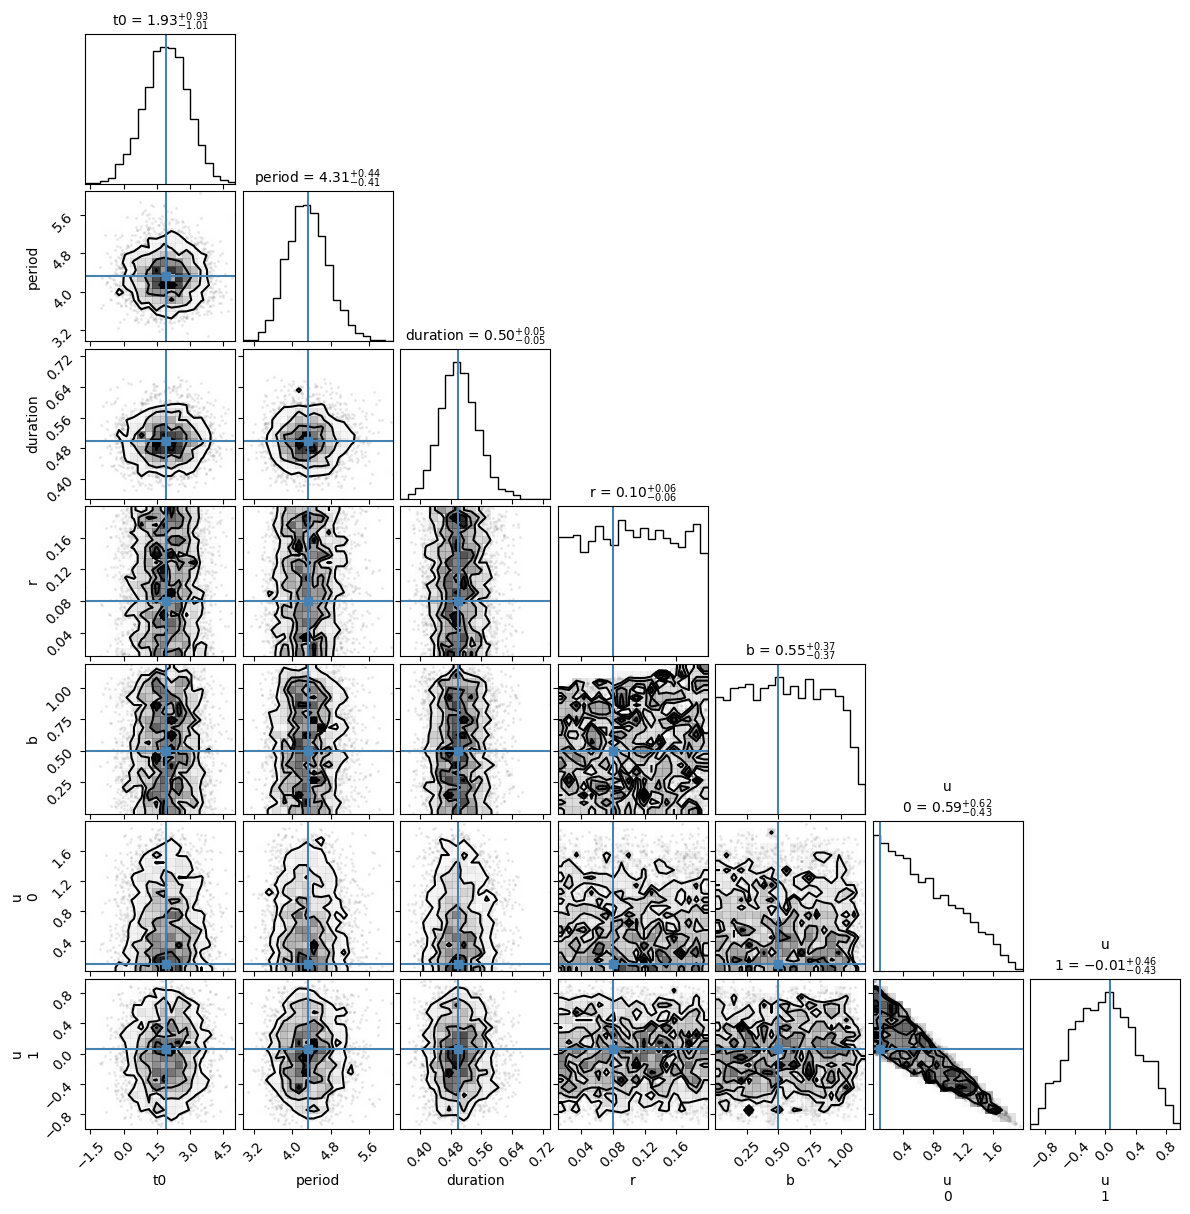

In [6]:
import corner

# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    truths=[T0, PERIOD, DURATION, ROR, B, U[0], U[1]],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
)


In [7]:
init_param_method = "true_values"  # "prior_median" or "true_values"

if init_param_method == "prior_median":
    print("Starting from the prior medians")
    run_optim = numpyro_ext.optim.optimize(
        model, init_strategy=numpyro.infer.init_to_median()
    )
elif init_param_method == "true_values":
    print("Starting from the true values")
    init_params = {
        "t0": T0,
        "logP": jnp.log(PERIOD),
        "logD": jnp.log(DURATION),
        "logR": jnp.log(ROR),
        "_b": B / (1 + ROR),
        "u": U,
    }
    run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
    )

opt_params = run_optim(jax.random.PRNGKey(3), time, yerr, y=y)

Starting from the true values


In [8]:
for k, v in opt_params.items():
    if k in ["light_curve", "obs", "_b"]:
        continue
    print(f"{k}: {v}")

t0: 1.9006881346290416
logP: 1.463258832176194
logD: -0.6875273036287336
r: 0.07782823039057753
u: [1.01637570e-91 5.15280847e-01]
b: 0.26005744595627184
duration: 0.5028178490316463
period: 4.320014817280567


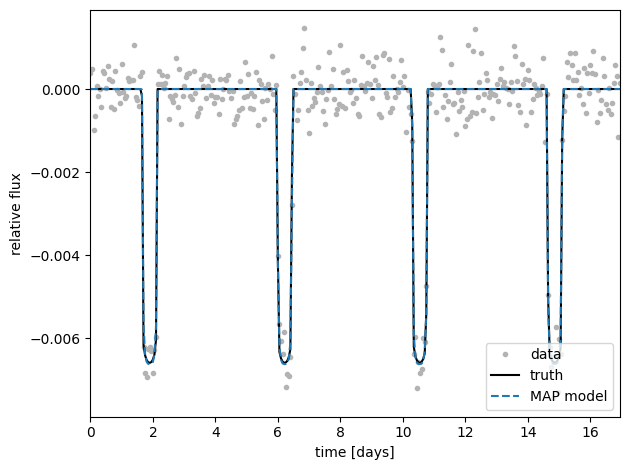

In [9]:
plt.plot(time, y, ".", c="0.7", label="data")
plt.plot(time, y_true, "-k", label="truth")
plt.plot(time, opt_params["light_curve"], "--C0", label="MAP model")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.legend(fontsize=10, loc=4)
plt.xlim(time.min(), time.max())
plt.tight_layout()


In [10]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        regularize_mass_matrix=True,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1), time, yerr, y=y)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [12]:
inf_data = az.from_numpyro(sampler)
samples = sampler.get_samples()
az.summary(inf_data, var_names=["t0", "period", "duration", "r", "b", "u"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,1.900,0.003,1.896,1.906,0.000,0.000,3322.0,2606.0,1.00
period,4.320,0.002,4.317,4.323,0.000,0.000,3192.0,2594.0,1.00
duration,0.505,0.006,0.493,0.517,0.000,0.000,1063.0,1538.0,1.00
r,0.079,0.001,0.077,0.081,0.000,0.000,528.0,888.0,1.01
b,0.428,0.186,0.045,0.663,0.009,0.005,465.0,555.0,1.01
u[0],0.148,0.111,0.000,0.344,0.002,0.002,1839.0,1901.0,1.00
u[1],0.162,0.212,-0.190,0.558,0.008,0.007,925.0,991.0,1.00


In [13]:
# There's also a method to obtain similar results to `az.summary` but directly
# as a method with the MCMC sampler. It also gives us the number of divergences.
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _b      0.40      0.17      0.46      0.09      0.61    421.25      1.01
      logD     -0.68      0.01     -0.68     -0.70     -0.66   1069.64      1.00
      logP      1.46      0.00      1.46      1.46      1.46   2910.27      1.00
         r      0.08      0.00      0.08      0.08      0.08    481.90      1.01
        t0      1.90      0.00      1.90      1.90      1.90   3211.36      1.00
      u[0]      0.15      0.11      0.12      0.00      0.31   2071.12      1.00
      u[1]      0.16      0.21      0.13     -0.18      0.49    817.76      1.00

Number of divergences: 0


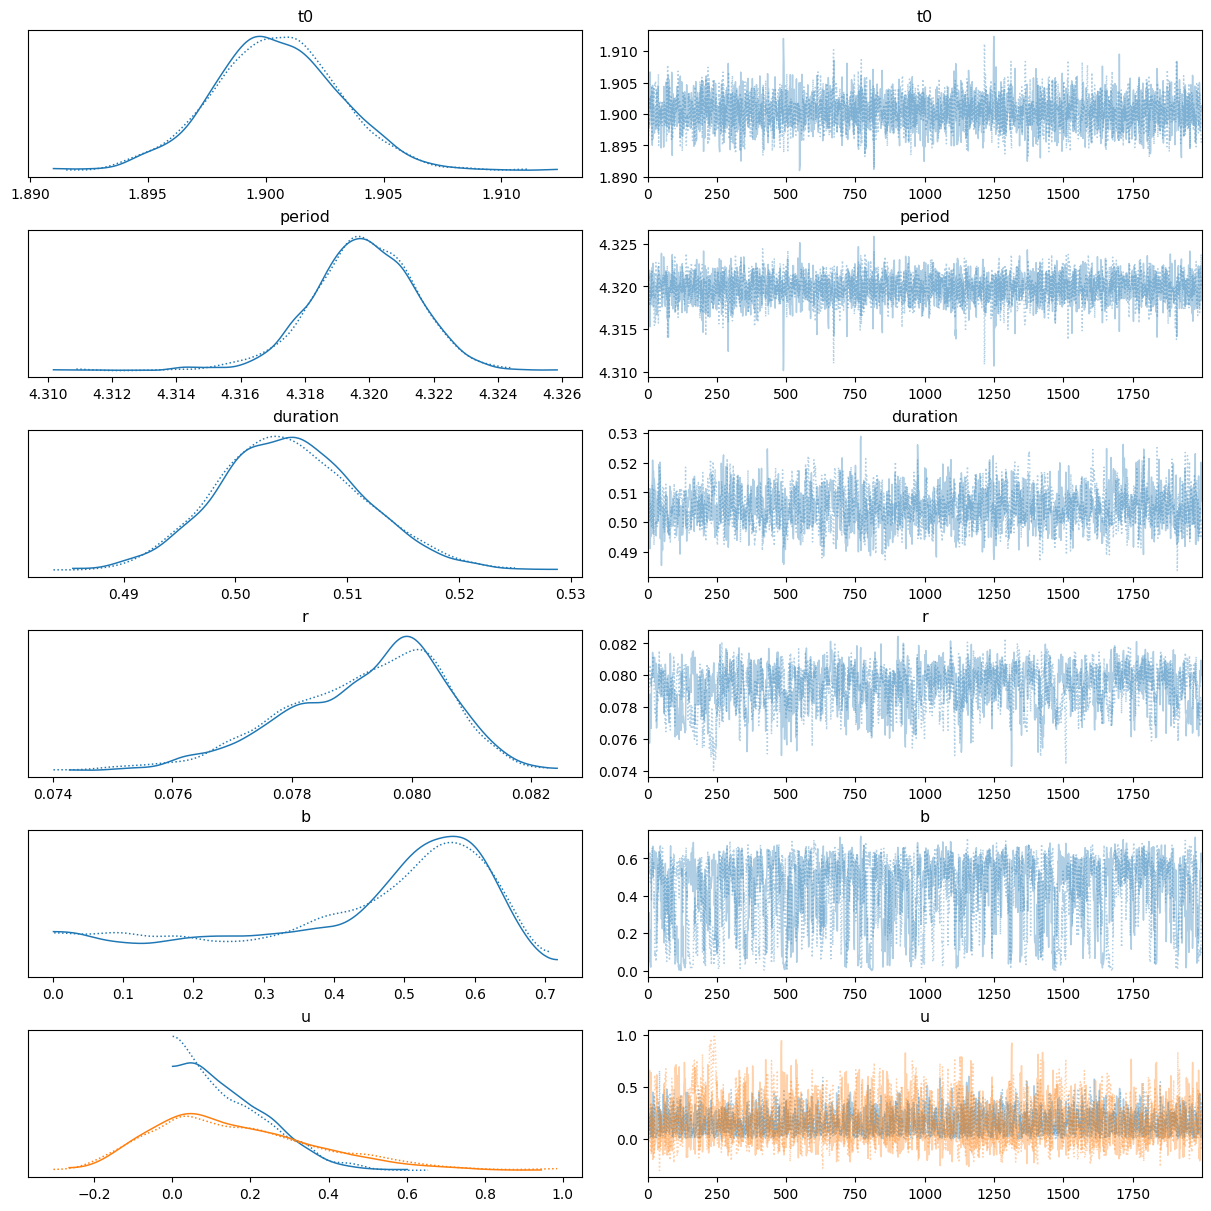

In [14]:
_ = az.plot_trace(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    backend_kwargs={"constrained_layout": True},
)

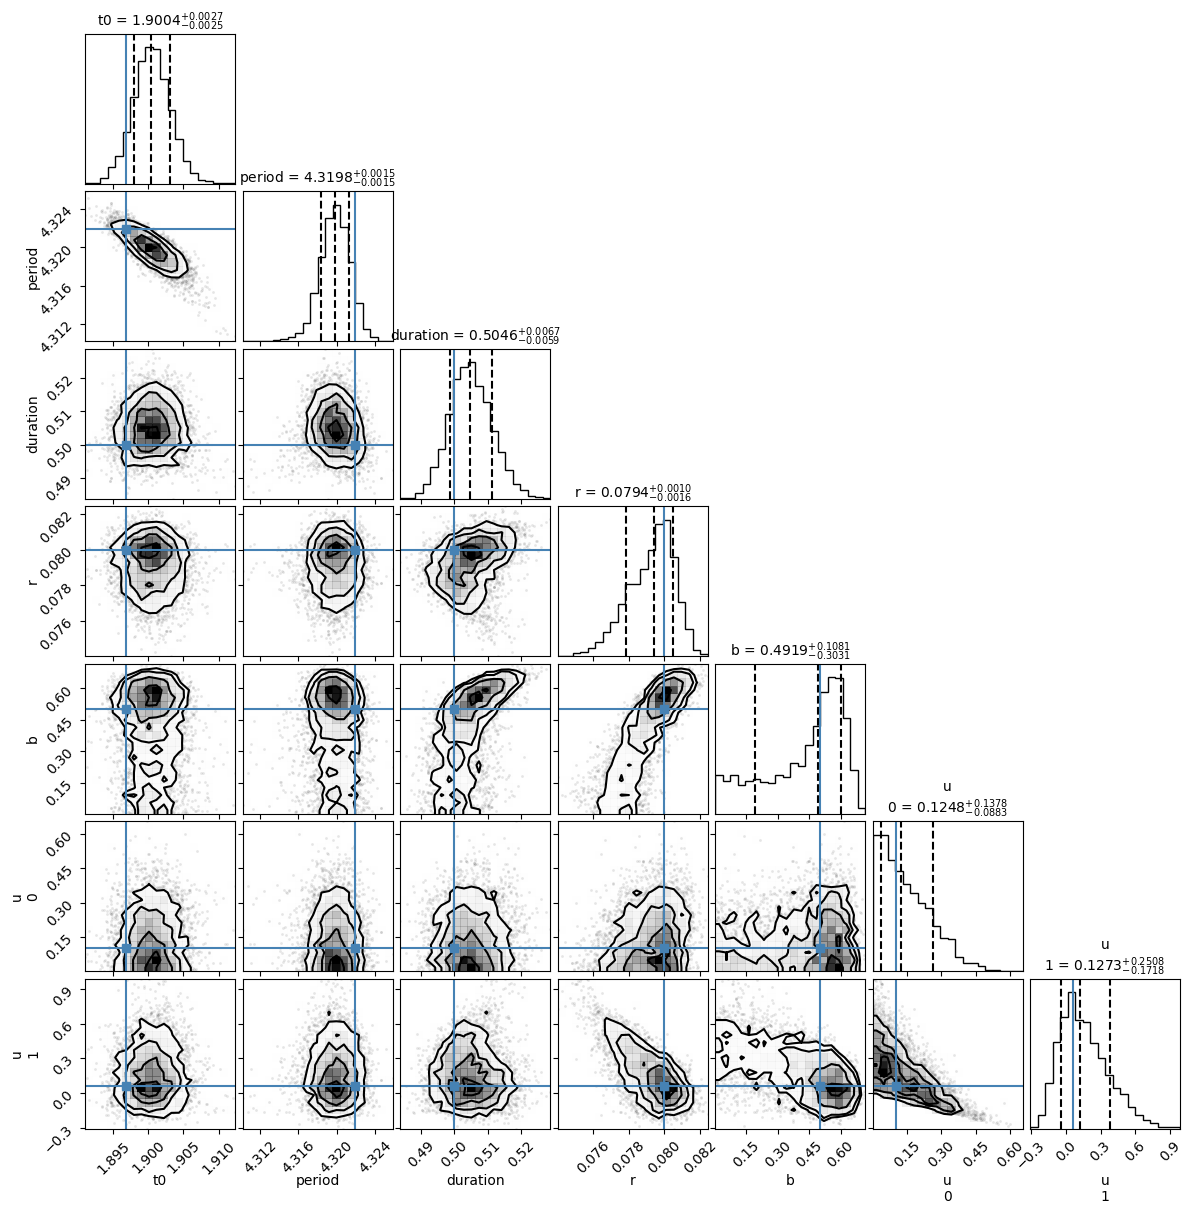

In [15]:
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    truths=[T0, PERIOD, DURATION, ROR, B, U[0], U[1]],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".4f",
    fig=fig,
)


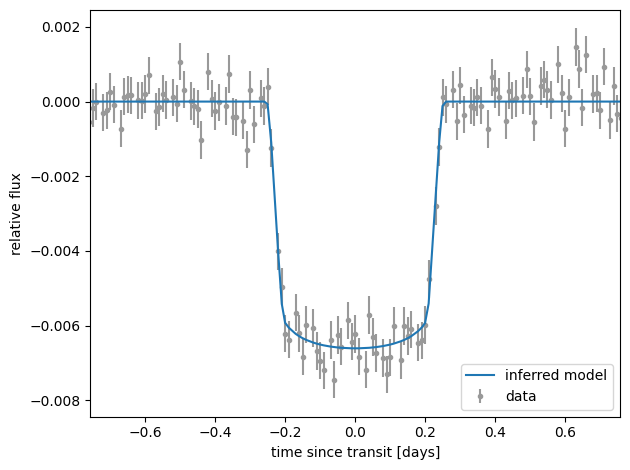

In [16]:
inferred_params = {
    "t0": np.median(samples["t0"]),
    "period": np.median(samples["period"]),
    "duration": np.median(samples["duration"]),
    "r": np.median(samples["r"]),
    "b": np.median(samples["b"]),
    "u": np.median(samples["u"], axis=0),
}


y_model = light_curve_model(time, inferred_params)

fig, ax = plt.subplots()

# Plot the folded data
t_fold = (
    time - inferred_params["t0"] + 0.5 * inferred_params["period"]
) % inferred_params["period"] - 0.5 * inferred_params["period"]
ax.errorbar(t_fold, y, yerr=yerr, fmt=".", color="0.6", label="data", zorder=-100)

# Plot the folded model
inds = np.argsort(t_fold)
ax.plot(t_fold[inds], y_model[inds], color="C0", label="inferred model")
ax.set_xlim(inferred_params["duration"] * jnp.array([-1, 1]) * 1.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("relative flux")
ax.legend(loc=4)
plt.tight_layout()